In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
import seaborn as sns

In [2]:
users = pd.read_csv('ab_users_data.csv')
orders =pd.read_csv('ab_orders.csv')
products = pd.read_csv('ab_products.csv')

In [3]:
print(users.isnull().any().any())
print(orders.isnull().any().any())
print(products.isnull().any().any())

False
False
False


In [4]:
users.head(2)

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1


In [5]:
orders.head(2)

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"


In [6]:
products.head(2)

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0


In [7]:
# отмененные заказы
print(users.shape)
print(users.query('action == "create_order"').shape)
print(users.query('action == "cancel_order"').shape)
# 214 заказов были отменены, они указаны в таблице дважды

(4337, 6)
(4123, 6)
(214, 6)


In [9]:
# Проверю среднее количество заказов у двух групп пользователей
# Отмененные заказы тоже буду учитывать в этой метрике. Это очень спорное решение, но исхлжу из того, что если заказ был сделан,
# то у пользователя было намерение приобрести товар, значит система рекомендаций дала результат, то что заказ был отменен и не 
# принес бизнесу прибыль - уже другой вопрос, к этому я вернусь позже
# сначала надо убрать дублирующииеся заказы
users_all_orders = users.query('action == "create_order"')
number_of_orders_from_user = users_all_orders.groupby(['group', 'user_id'], as_index = False).size()

In [10]:
number_of_orders_from_user_0 = number_of_orders_from_user.query('group == 0')
number_of_orders_from_user_1 = number_of_orders_from_user.query('group == 1')

In [12]:
number_of_orders_from_user_0.head(1)

,group,user_id,size
0,0,964,2


In [13]:
number_of_orders_from_user_1.head(1)

,group,user_id,size
515,1,965,9


(array([ 29.,  36.,   0.,  38.,   0., 117., 106.,   0.,  58.,   0.,  55.,
         28.,   0.,  18.,   0.,  11.,   2.,   0.,   2.,   2.]),
 array([ 1. ,  1.6,  2.2,  2.8,  3.4,  4. ,  4.6,  5.2,  5.8,  6.4,  7. ,
         7.6,  8.2,  8.8,  9.4, 10. , 10.6, 11.2, 11.8, 12.4, 13. ]),
 <a list of 20 Patch objects>)

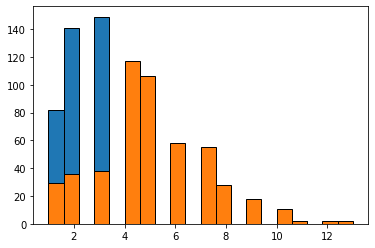

In [16]:
plt.hist (number_of_orders_from_user_0['size'], edgecolor='black', bins=20)
plt.hist (number_of_orders_from_user_1['size'], edgecolor='black', bins=20)
# распределения не нормальны, но, если прологарифмировать данные, распределения будут околонормальными

In [19]:
log_number_of_orders_from_user_0 = np.log(number_of_orders_from_user_0['size'])
log_number_of_orders_from_user_1 = np.log(number_of_orders_from_user_1['size'])

In [22]:
# Тест на нормальность
shapiro(log_number_of_orders_from_user_0)
shapiro(log_number_of_orders_from_user_1)
# Не помогло, распределения все равно не нормальны. Значений достаточно много, т - тест можно провести,  !!! но он не будет надежным

ShapiroResult(statistic=0.8944880366325378, pvalue=4.335773886995714e-18)

In [23]:
print(scipy.stats.ttest_ind(log_number_of_orders_from_user_0, log_number_of_orders_from_user_1))
print(scipy.stats.ttest_ind(number_of_orders_from_user_0['size'], number_of_orders_from_user_1['size']))
# значимые статистические различия

Ttest_indResult(statistic=-14.781479416363863, pvalue=6.342933083704138e-45)
Ttest_indResult(statistic=-14.51086812343365, pvalue=1.6974865514796019e-43)


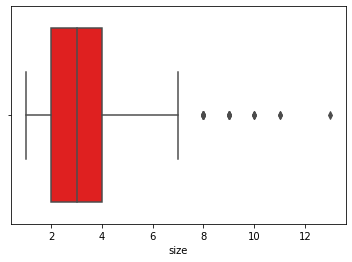

In [26]:
# Но безоговорочно доверять такому т - тесту нельзя (из-за несоблюдения условия номальности), посмотрю боксплоты
sns.boxplot(data = number_of_orders_from_user_0, x = 'size', color = 'r')

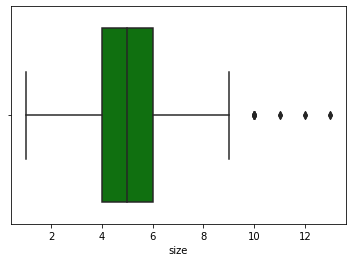

In [27]:
sns.boxplot(data = number_of_orders_from_user_1, x = 'size', color = 'g')
# Боксплоты очень наглядно показывают, что среднее количество заказов выросло у пользователей с новой системой рекомендаций
# 1, 2 и 3-й перцентили сдвинулись вверх (все примерно на две покупки), как и верхняя граница
# СРЕДНЕЕ КОЛИЧЕСТВО ЗАКАЗОВ УВЕЛИЧИЛОСЬ

In [28]:
# посмотрю, как много заказов отменяются в каждой группе

In [29]:
users_0 = users.query('group == 0')
users_1 = users.query('group == 1')
print(users_0.shape)
print(users_0.query('action =="cancel_order"').shape)
print(users_1.shape)
print(users_1.query('action =="cancel_order"').shape)

(1691, 6)
(82, 6)
(2646, 6)
(132, 6)


In [30]:
print(1691 - 82 * 2)
print(2646 - 132 * 2)

1527
2382


In [31]:
freim_about_numbes_off_order_depending_on_action = pd.DataFrame({'group_0': [1527, 82],
 'group_1': [2382, 132],
})
freim_about_numbes_off_order_depending_on_action

,group_0,group_1
0,1527,2382
1,82,132


In [32]:
chi2_contingency(freim_about_numbes_off_order_depending_on_action)
# Не могу исключить нулевую гипотезу. p-value очень велико, вряд ли есть статистически значимая разница в отмененных заказах

(0.021274207290295187,
 0.8840344321879333,
 1,
 array([[1525.48653893, 2383.51346107],
        [  83.51346107,  130.48653893]]))

In [33]:
# Теперь посмотрю на количество товаров в чеках
orders['quantity_of_products'] = orders['product_ids'].apply(lambda x: len(x))
#apply(lambda x: len(x))

In [34]:
orders.head(1)

,order_id,creation_time,product_ids,quantity_of_products
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",16


In [35]:
orders.dtypes

order_id                 int64
creation_time           object
product_ids             object
quantity_of_products     int64
dtype: object

In [36]:
orders['product_ids'] = orders['product_ids'].str.replace('{', '')
orders['product_ids'] = orders['product_ids'].str.replace('}', '')
orders['product_ids'] = orders['product_ids'].str.strip(",")
orders['product_ids'] = orders['product_ids'].str.split(',')

In [37]:
orders['quantity_of_products'] = orders['product_ids'].str.len()

In [38]:
all_orders_with_quantity_of_products = orders.merge(users, on = 'order_id')

In [39]:
all_orders_with_quantity_of_products = all_orders_with_quantity_of_products.query('action == "create_order"')

In [40]:
all_orders_with_quantity_of_products_0 = all_orders_with_quantity_of_products.query('group == 0')
all_orders_with_quantity_of_products_1 = all_orders_with_quantity_of_products.query('group == 1')

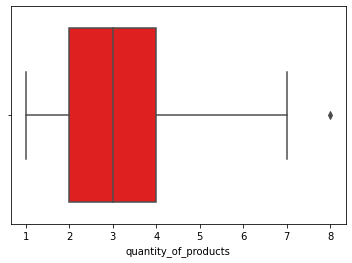

In [41]:
sns.boxplot(data = all_orders_with_quantity_of_products_0, x = 'quantity_of_products', color = 'r')

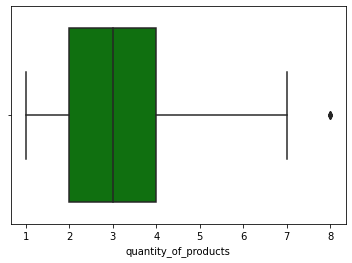

In [42]:
sns.boxplot(data = all_orders_with_quantity_of_products_1, x = 'quantity_of_products', color = 'g')

In [43]:
# На боксплотах видно, что различий нет, но, на всякий случай, проверю.
#Если получится привести распределения к понрмальности, то возьму т - тет, если нет, то критерий Манна-Уитни

In [44]:
log_all_orders_with_quantity_of_products_0 = np.log(all_orders_with_quantity_of_products_0['quantity_of_products'])
log_all_orders_with_quantity_of_products_1 = np.log(all_orders_with_quantity_of_products_1['quantity_of_products'])

In [45]:
print(shapiro(log_all_orders_with_quantity_of_products_0))
print(shapiro(log_all_orders_with_quantity_of_products_1))

ShapiroResult(statistic=0.9065202474594116, pvalue=2.616071329393423e-30)
ShapiroResult(statistic=0.9044011831283569, pvalue=4.566310636413604e-37)


In [46]:
scipy.stats.mannwhitneyu(all_orders_with_quantity_of_products_0['quantity_of_products'], all_orders_with_quantity_of_products_1['quantity_of_products'])
#статистически значимых различий в количестве товаров в заказе не обнаружил

MannwhitneyuResult(statistic=2013211.0, pvalue=0.797659849654466)

In [47]:
# посмотрю, есть ли разница  в стоимости заказов по двум группам

In [48]:
all_infa = users_all_orders.merge(orders, on = 'order_id')

In [49]:
all_infa = all_infa.explode('product_ids')
all_infa = all_infa.rename(columns = {'product_ids': 'product_id'})

In [50]:
all_infa['product_id'] = all_infa['product_id'].astype (int)

In [51]:
all_infa = all_infa.merge(products, on = "product_id")

In [52]:
all_infa.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,quantity_of_products,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,4,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36.000000,2022-08-26,0,2022-08-26 00:31:36.000000,75,2,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26 03:01:40.000000,2022-08-26,1,2022-08-26 03:01:40.000000,75,6,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22.000000,2022-08-26,1,2022-08-26 04:01:22.000000,75,6,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05.000000,2022-08-26,1,2022-08-26 06:04:05.000000,75,4,сок ананасовый,120.0


In [53]:
money_for_order = all_infa.groupby(['group', 'order_id'], as_index = False).price.sum()

In [54]:
money_for_order_0 = money_for_order.query('group == 0')
money_for_order_1 = money_for_order.query('group == 1')

In [55]:
shapiro(money_for_order_0['price'])

ShapiroResult(statistic=0.9185957908630371, pvalue=1.347362172388217e-28)

In [56]:
shapiro(money_for_order_1['price'])

ShapiroResult(statistic=0.9023671746253967, pvalue=2.2913337444601104e-37)

In [57]:
log_money_for_order_0 = np.log(money_for_order_0['price'])
log_money_for_order_1 = np.log(money_for_order_1['price'])

In [58]:
print(shapiro(log_money_for_order_0))
print(shapiro(log_money_for_order_1))
#распределения не нормальны

ShapiroResult(statistic=0.9756762385368347, pvalue=7.114292192668729e-16)
ShapiroResult(statistic=0.9746667146682739, pvalue=1.0237394863902976e-20)


In [59]:
scipy.stats.ttest_ind(money_for_order_0['price'], money_for_order_1['price'])
# но т-тесту доверять нельзя из-за ненормальности распределния

Ttest_indResult(statistic=1.4815692121713073, pvalue=0.13853141121218765)

In [60]:
scipy.stats.mannwhitneyu(money_for_order_0['price'], money_for_order_1['price'])
# тоже недостаточно для отклонения нулевой гипотезы, но pvalue 7% достаточно низкое

MannwhitneyuResult(statistic=2089847.0, pvalue=0.07092841734481316)

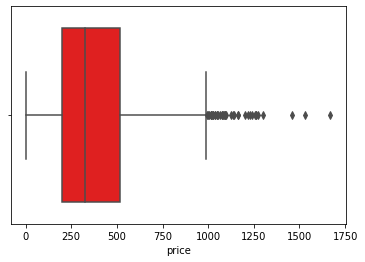

In [61]:
sns.boxplot(data = money_for_order_0, x = 'price', color = 'r')

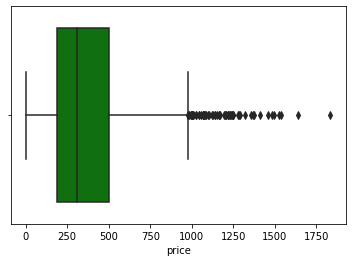

In [62]:
sns.boxplot(data = money_for_order_1, x = 'price', color = 'g')

In [ ]:
# По рассчитанным метрикам новая система рекомендаций точно не хуже старой, по одной статистически значимо лучше.
# Среднее количество заказов стало больше, я бы советовал ввести новую систему рекомендаций, но, если бы была возможность,
# Продлил тест еще на некоторое время, возможно, смог бы что-то сказать про средний чек. Статитстически значмых отличий 
# в средний чеках я не обнаружил, но при использовании критерия Манна-Уитни p-value около 7%, возможно, большая выборка
# позволила бы найти некоторые различия в группах по среднему чеку